In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import ttest_1samp, ttest_ind
from scipy import stats
from statsmodels.stats import weightstats as stests

from functools import wraps
import time

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

from sklearn.linear_model import LinearRegression, RANSACRegressor, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb

In [3]:
plt.style.use('seaborn')

In [4]:
%run CoreFunction.ipynb

In [5]:
TEST_SIZE=0.15 # Използваме 15% от данните за тестване и 85% за трениране
n_comp = 0.95 # PCA Explained Variance

In [6]:
scaler_min_max = MinMaxScaler()
scaler_z_score = StandardScaler()

# <span style="color:midnightblue"> ELECTRICITY LOAD FORECAST PROJECT</span>

Електричеството е основна човешка потребност и определено един от най-важните фактори за обществения прогрес. През последните десетилетия обаче електричеството навлезе на пазара като търгуема стока и енергетиката на много страни беше дерегулирана. С появата на този нов пазар се появи и необходимостта от надеждни методи за прогнозиране във всички мащаби (почасово, дневно, дългосрочно и т.н.) и това се превърна в голяма област на изследване. От друга страна световните енергийни системи са взаимосвързани, което предполага надежни методи за балансиране на енергийните товари. Отделно, специфичната природа на електроенергията, както и невъзможността тя да бъде съхранявана, изисква тези методи за балансиране да бъдат изключително точни и надеждни.

В рамките на фундаменталната промяна, световната енергийна система се оформя все по-крехка и по-податлива на шокове. В този ред на мисли, пред машинното обучение стои не леката задача да предостави качествени и надежни прогнозни модели, които да способстват за изглаждане на производствените и пазарните флуктуации.

## <span style="color:midnightblue"> 1. PROJECT OBJECTIVE</span>

Както цените на всяка стока, спот цените на електроенергията също се определят от търсенето и предлагането.
 
Търсенето на електроенергия е нееластично за отделни кратки период от време, което води до висока волатилност на цените. По отношение на генерирането на електричество, някои събития се случват произволно, като повреди в електроцентрали, мрежи, съоръжения, водещи до намален капацитет. Друг фактор, който променя все повече характеристиките на генерацията на електроенергията е все по толерираното участие на зелените енергии в енергийните миксове на държавите.
Може да звучи лесно за прогнозиране, но електричеството е много специална стока, тъй като не може да се съхранява по икономически осъществим начин.

Това обстоятелство, както и необходимостта от стабилност на системата, налагат търсенето и предлагането да бъдат постоянно балансирани, което понастоящем се осъществява от т.нар. системни оператори на електроенергия, за които е от съществено значение да разполагат с надеждни прогнози за спот цените и генерацията.

### <span style="color:darkgreen"> __Целта на този проект е да даде почасова прогноза за общата генерация на електрическа енергия за пет дни напред.__</span>  

## <span style="color:midnightblue"> 2. PROJECT ARCHITECTURE</span>

Файловете на проекта са разположени в папка __ElectricityForecastProject__. Архитектурата е посочена в по-долната фигура:

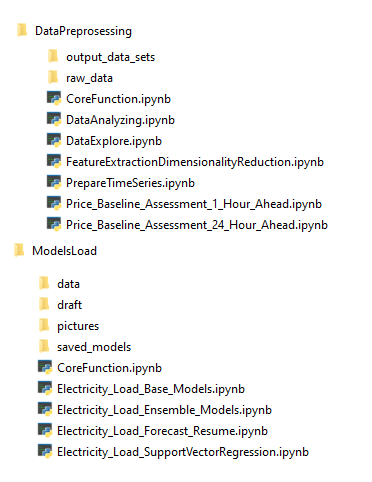

В папка __DataPreprosessing__ са файловете с предварителната обработка и анализа на данните.
В папка __LoadModels__ - са файловете __Electricity_Load_Base_Models.ipynb__, __Electricity_Load_SupportVectorRegression.ipynb__ и __Electricity_Load_Ensemble_Models.ipynb__, съдържащи информацията за обучението на моделите, предварителният им анализ и първоначалният подбор. В __CoreFunction.ipynb__ са изнесени повечето спомагателни функции. __Electricity_Load_Forecast_Resume.ipynb__ представлява резюме, с обобщение на проекта.


## <span style="color:midnightblue"> 3. DATA <span>

Набора от данни съдържа два .csv файла, които съдържат почасова информация за производството на електроенергия и метеорологични данни за пет областни града в Испания за периода 2015-2019 (4 години). По-специално:

__"weather_features.csv"__: Съдържа почасова информация за метеорологичните условия (напр. температура, скорост на вятъра, влажност, валежи, качествено описание) на 5 големи града в Испания (Мадрид, Барселона, Валенсия, Севиля и Билбао).

__„energy_dataset.csv“__: Съдържа почасова информация за генерирането на енергия в Испания. По-специално, има информация (в MW) за количеството електроенергия, генерирана от различните енергийни източници (изкопаем газ, изкопаеми въглища и вятърна енергия доминират в енергийната мрежа), както и за общото натоварване (потребление на енергия) на националната мрежа и цената на енергията (€/MWh).

Двата сета са предоставени в www.kaggle.com и могат да бъдат изтеглени от следният линк:<br>
https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather  <br>
Hourly energy demand generation and weather <br>

Предварителната обработка на данните, анализа, подготовката за машинна обработка, както и приготвянето на времевите серии се намират в директория __DataPreprosessing__ във файлове:
- __DataExplore.ipynb__, 
- __DataAnalyzing.ipynb__, 
- __FeatureExtractionDimensionalityReduction.ipynb__,
- __PrepareTimeSeries.ipynb__. 

Редът, в който са посочени файловете по-горе, показва последователността на обработката на данните. Съдържат и кратки бележки и пояснения. Окончателните time series са изведени в отделни файлове в директория __output_data_sets__<br>

В __CoreFunction.ipynb__ е предоставен автоматизиран процес на трансформация на данните - четене, скалиране и PCA-трансформация на измеренията. Тук, с оглед прегледност, ще ползваме само него.

Data shapes:
Atributes shape:(34202, 798), Targets shape: (34202, 120)
Train atributes shape:(29071, 798), Train targets shape: (29071, 120)
Test atributes shape:(5131, 798), Test targets shape: (5131, 120)



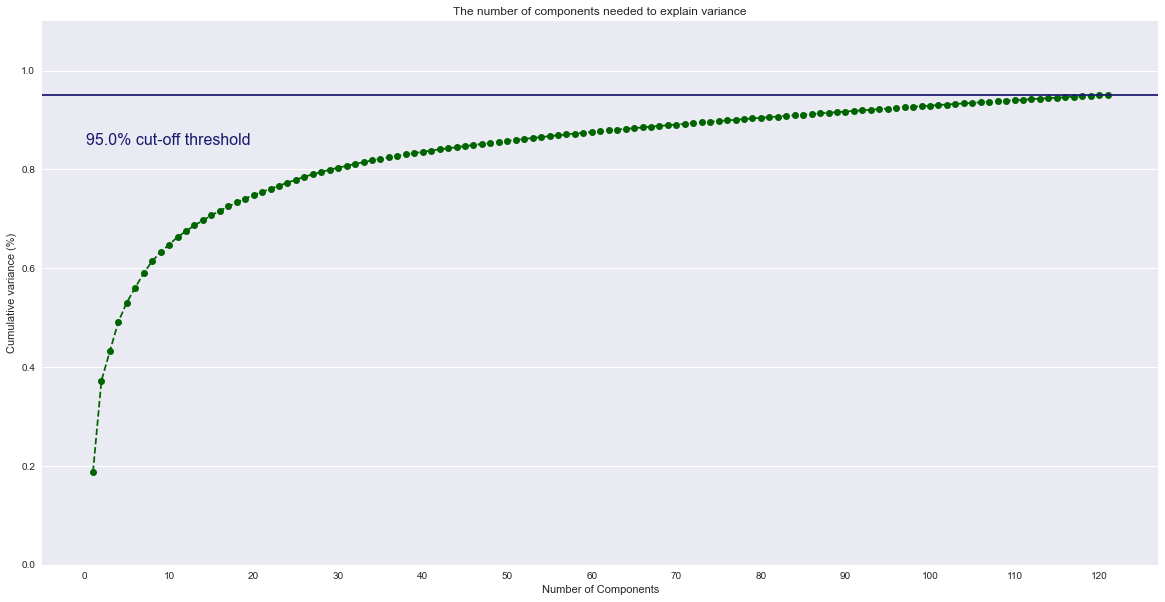

Transformed train shape: (29071, 121)
Transformed test shape: (5131, 121)
Function took 3.2018 seconds


In [7]:
#Четене на данните
load_target, load_attribute, df_data_load = read_data("total load actual",  r"data\df_data_load_ts720_120_24.csv")
# Скалиране с StandardScaler
load_atribute_train, load_atribute_test, load_target_train, load_target_test, load_attribute_col_names = scaled_data(load_target, load_attribute, TEST_SIZE, scaler_z_score)
print(f"Data shapes:")
print(f"Atributes shape:{load_attribute.shape}, Targets shape: {load_target.shape}")
print(f"Train atributes shape:{load_atribute_train.shape}, Train targets shape: {load_target_train.shape}")
print(f"Test atributes shape:{load_atribute_test.shape}, Test targets shape: {load_target_test.shape}\n")

# Редукция на данните.
most_important_features, PC_train, PC_test = PCA_feature_preprocessing(load_atribute_train, load_atribute_test, n_comp = n_comp, col_names = load_attribute.columns)


## <span style="color:midnightblue"> 4. MODELS <span>

In [8]:
df_results = pd.DataFrame(columns=['Model','Data', 'mse_train', 'mae_train', 'rmse_train', 'r2_train', 'predicted_train_mean', 
                                    'predicted_train_std', 'mse_test', 'mae_test', 'rmse_test', 'r2_test', 
                                    'predicted_test_mean', 'predicted_test_std','pval_ztest_r2','pval_ttest_r2',
                                    'pval_ztest_mae', 'pval_ttest_mae', 'model_filename'])

In [9]:
def add_model(df_results, df_current_model_results):
    df_results = df_results.append(df_current_model_results, ignore_index = True)
    return df_results

В процеса на работа бяха създадени и изследвани множество модели, от които са подбрани осем. Ще ги разгледаме поетапно. Сложността на заданието се определя от факта, че искаме педневна, почасова прогноза (120 таргета) за общата генерация на електроенергия, на база от предходните 30 дни, както и от множество екзогенни променливи. При това искаме нашата прогноза да е отместена от втория до шестият ден. Това означава, че трябва да обучаваме едновременно 120 регресионни алгоритъма и да комбинираме резултате от тях. <br>

Scikit-learn стандартно поддържа алгоритми за машинно обучение, които са предназначени за прогнозиране на една числова стойност. Някои алгоритми в библиотеката, обаче поддържат многоизходна(многоцелева) регресия, като LinearRegression, DecisionTree, RandomForestRegressor.
Съществуват и специални модели за заобикаляне, които могат да се използват за обвиване и използване на тези алгоритми, които не поддържат естествено предсказване на множество изходи.<br>

В проекта основно като обвивка за многоизходна регресия е ползвана разработената в Scikit-learn стратегия MultiOutputRegressor. В един от алгоритмите е изследвано поведението и на RegressorChain, който показа изключително слаби резултати по отношение на поставената задача и затова не е представен в резюмето. Основната разлика в двете обвивки е начина на прогнозиране. MultiOutputRegressor дава отделни прогнози за всеки един от таргетите(директен мултиизход), докато RegressorChain работи на верижен принцип и ползва за прогнозиране на всеки следваш таргет, прогнозата за предходния (Верижен изход). 

Тъй като данните съдържат информация за прогнозираната средна генерация за ден напред от съществуващ модел, предварително беше направена оценка на точността на този модел. По долу са представени резултатите от тази оценка:

- Score Results:
- Mean squared error: 206707.53
- Root mean squared error: 454.65
- Mean absolute error: 316.89
- Coefficient of determination: 0.9901
- Predicted mean: 28712.130 (4594.035)
- Actual mean: 28698.281 (4575.764)

В това резюме разглеждаме резултатите от готовите (тренирани, оптимизирани и подбрани) модели, които по-долу ще сравним. Подробни данни за начина на оптимизация (съответно, бележки към тях), са предоставени в описаните по-горе файлове. Метриките за оценка на всеки един от моделите се събират в pd.DataFrame за да бъдат ползвани по-късно за сравнителен анализ. Целта на този анализ е да се подберат най-надежните модели, които да послужат за прогнозиране на почасовата генерация на електрическата енергия.

#### Ползвани Метрики

- __Средната квадратна грешка__ (Mean squared error - MSE) Дефинираме MSE като средна стойност на квадратите на разликите между действителната и прогнозираната стойност.  MSE наказва модела за допускане на големи грешки, като ги повдига на квадрат и това свойство я прави по-малко стабилна спрямо отклоненията. Ако данните са склонни към много отклонения трябва да се тълкува внимателно.
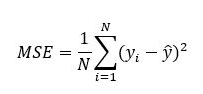

- __Средноквадратична грешка__ (Root mean squared error - RMSE) - Корен квадратен от MSE. Използва естествените единици данни.
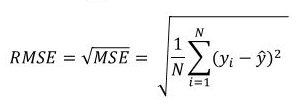

- __Средна абсолютна грешка__ (Мean_absolute_error - MAE) Дефинираме MAE като средна стойност на абсолютните разлики между действителната и прогнозираната стойност. MAE е по-стабилна спрямо отклоненията в сравнение с MSE. По удобна метрика, ако данните са склонни към много отклонения. 
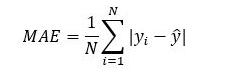

- __Коефициент на определеност__ (Coefficient of determination - R2) - Тази метрика показва процента на дисперсията в зависимата променлива, която независимите променливи обясняват колективно. Оценява разсейването на точките от данни около регресионната линия. Нарича се още коефициент на детерминация или коефициент на множествена детерминация за множествена регресия.
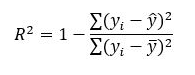

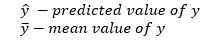


## <span style="color:midnightblue"> 4.1 Base Models<span> 

 ### <span style="color:midnightblue"> Linear Regression - Base Model<span>
<span style="color:darkgreen">__Electricity_Load_Base_Models.ipynb__<span> 

In [10]:
model_filename = "#load_linear_regression.sav"
model = load_model(model_filename)
df_current_model_results  = evaluation_report_df(model, load_atribute_train, load_target_train, 
                                                 load_atribute_test, load_target_test, model_filename, 
                                                 tranformed_data = False, wrapper = None)
df_results = add_model(df_results, df_current_model_results)

In [11]:
model

LinearRegression()

In [12]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,6826651.7375,7173968.5838
Mean absolute error,1969.6976,2019.7655
Root mean squared error,2612.6046,2677.9044
Coefficient of determination,0.6707,0.6537
Predicted mean,28672.2041,28652.5014
Predicted_std,3729.1621,3718.9588


 ### <span style="color:midnightblue"> Linear Regression with PCA data transformation<span>
 <span style="color:darkgreen">__Electricity_Load_Base_Models.ipynb__<span> 

In [13]:
model_filename = "#load_linear_regression_pca.sav"
model = load_model(model_filename)
df_current_model_results  = evaluation_report_df(model, PC_train, load_target_train, 
                                                 PC_test, load_target_test, model_filename, 
                                                 tranformed_data = True, wrapper = None)
df_results = add_model(df_results, df_current_model_results)

In [14]:
model

LinearRegression()

In [15]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,7222351.3215,7208008.9489
Mean absolute error,2032.1534,2031.8694
Root mean squared error,2687.3802,2684.4336
Coefficient of determination,0.6517,0.652
Predicted mean,28672.2041,28648.2251
Predicted_std,3675.7245,3668.1087


 ### <span style="color:midnightblue"> Linear Regression with Regularization - Ridge<span>
 <span style="color:darkgreen">__Electricity_Load_Base_Models.ipynb__<span> 

In [16]:
model_filename = "#load_ridge.sav"
model = load_model(model_filename).best_estimator_
df_current_model_results  = evaluation_report_df(model, load_atribute_train, load_target_train, 
                                                 load_atribute_test, load_target_test, model_filename, 
                                                 tranformed_data = False, wrapper = None)
df_results = add_model(df_results, df_current_model_results)

In [17]:
model

Ridge(alpha=2000)

In [18]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,6884107.8088,6967325.1452
Mean absolute error,1978.6471,1991.613
Root mean squared error,2623.6043,2639.0841
Coefficient of determination,0.668,0.6637
Predicted mean,28672.2041,28652.0739
Predicted_std,3692.2419,3680.8621


### <span style="color:midnightblue"> Linear Support Vector Regression with wrapper MultiOutputRegressor<span>
<span style="color:darkgreen">__Electricity_Load_SupportVectorRegression.ipynb__<span> 

In [19]:
model_filename = "#load_svr_oplimal.sav"
model = load_model(model_filename)
df_current_model_results  = evaluation_report_df(model, PC_train, load_target_train, 
                                                 PC_test, load_target_test, model_filename, 
                                                 tranformed_data = False, wrapper = 'MultiOutputRegressor')
df_results = add_model(df_results, df_current_model_results)

In [20]:
model.get_params() 

{'estimator__C': 10,
 'estimator__dual': False,
 'estimator__epsilon': 0.0,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1.0,
 'estimator__loss': 'squared_epsilon_insensitive',
 'estimator__max_iter': 1000,
 'estimator__random_state': 42,
 'estimator__tol': 0.001,
 'estimator__verbose': 0,
 'estimator': LinearSVR(C=10, dual=False, loss='squared_epsilon_insensitive', random_state=42,
           tol=0.001),
 'n_jobs': None}

In [21]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,7222466.9556,7208046.653
Mean absolute error,2032.2196,2031.9185
Root mean squared error,2687.4017,2684.441
Coefficient of determination,0.6516,0.652
Predicted mean,28669.4724,28645.4501
Predicted_std,3674.7012,3667.1325


## <span style="color:midnightblue"> 4.2 Ensemble Models<span>

### <span style="color:midnightblue"> Random Forest Regression<span>
<span style="color:darkgreen">__Electricity_Load_Ensemble_Models.ipynb__<span> 

In [22]:
model_filename = "#load_random_forest_regression_optimal.sav"
model = load_model(model_filename)
df_current_model_results  = evaluation_report_df(model, load_atribute_train, load_target_train, 
                                                 load_atribute_test, load_target_test, model_filename, 
                                                 tranformed_data = False, wrapper = None)
df_results = add_model(df_results, df_current_model_results)

In [23]:
model

RandomForestRegressor(max_depth=15, max_features='sqrt', max_leaf_nodes=600,
                      n_estimators=40, random_state=42)

In [24]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,6360862.2702,7311949.5639
Mean absolute error,1916.7323,2051.4722
Root mean squared error,2521.6761,2703.9268
Coefficient of determination,0.6932,0.647
Predicted mean,28668.7174,28662.1321
Predicted_std,3292.0683,3239.4569


### <span style="color:midnightblue"> AdaBoost with DecisionTreeRegressor<span>
<span style="color:darkgreen">__Electricity_Load_Ensemble_Models.ipynb__<span> 

In [25]:
model_filename = "#ada_load_wrapped_pca_3.sav"
model = load_model(model_filename)
df_current_model_results  = evaluation_report_df(model, PC_train, load_target_train, 
                                                 PC_test, load_target_test, model_filename, 
                                                 tranformed_data = True, wrapper = 'MultiOutputRegressor')
df_results = add_model(df_results, df_current_model_results)

In [26]:
model

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                                                      min_samples_leaf=50),
                                                 learning_rate=1,
                                                 n_estimators=30))

In [27]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,7553676.1726,7977991.3425
Mean absolute error,2191.1249,2231.832
Root mean squared error,2748.3145,2824.3352
Coefficient of determination,0.6357,0.6149
Predicted mean,28555.8397,28550.6941
Predicted_std,3220.9921,3209.8664


### <span style="color:midnightblue"> AdaBoost with LinearSVR<span>
<span style="color:darkgreen">__Electricity_Load_Ensemble_Models.ipynb__<span> 

In [28]:
model_filename = "#ada_load_wrapped_svr_pca.sav"
model = load_model(model_filename)
df_current_model_results  = evaluation_report_df(model, PC_train, load_target_train, 
                                                 PC_test, load_target_test, model_filename, 
                                                 tranformed_data = True, wrapper = 'MultiOutputRegressor')
df_results = add_model(df_results, df_current_model_results)

In [29]:
model

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=LinearSVR(C=10,
                                                                          dual=False,
                                                                          loss='squared_epsilon_insensitive',
                                                                          random_state=42,
                                                                          tol=0.001),
                                                 learning_rate=1,
                                                 n_estimators=10))

In [30]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,7568800.0827,7579790.4059
Mean absolute error,2140.921,2140.9341
Root mean squared error,2750.8597,2752.6986
Coefficient of determination,0.6349,0.6341
Predicted mean,28547.0802,28530.878
Predicted_std,3508.4448,3502.9205


### <span style="color:midnightblue"> Extreme Gradient Boosting<span>
<span style="color:darkgreen">__Electricity_Load_Ensemble_Models.ipynb__<span> 

In [31]:
model_filename = "#load_xgb_end_test_1.sav"
model = load_model(model_filename)
df_current_model_results  = evaluation_report_df(model, PC_train, load_target_train, 
                                                 PC_test, load_target_test, model_filename, 
                                                 tranformed_data = True, wrapper = 'MultiOutputRegressor')
df_results = add_model(df_results, df_current_model_results)
# df_results.at[df_results.index[-1],'Model']="MultiOutputRegressor_XGBRegressor1_PCA_data"

In [32]:
model

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.7, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.73,
                                            enable_categorical=False, gamma=0.2,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2,
                                            max_delta_step=None, max_depth=4,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=250, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=N

In [33]:
get_current_model_evaluation_report(df_current_model_results)

,Train,Test
Metric,,
Mean squared error,2021099.412,3160435.3776
Mean absolute error,1067.3974,1332.4527
Root mean squared error,1421.5262,1777.5624
Coefficient of determination,0.9025,0.8474
Predicted mean,28671.939453,28676.371094
Predicted_std,4067.457275,3956.527588


## <span style="color:midnightblue"> 5. MODELS COMPARISON <span>

__Оценка на съществуващият модел__
- Score Results:
- Mean squared error: 206707.53
- Root mean squared error: 454.65
- Mean absolute error: 316.89
- Coefficient of determination: 0.9901
- Predicted mean: 28712.130 (4594.035)
- Actual mean: 28698.281 (4575.764)

R2 е мярка за съответствие за линейни регресионни модели. 
Тази статистика показва процента на дисперсията в зависимата променлива, която независимите променливи обясняват колективно.
R2 измерва силата на връзката между модела и зависимата променливал. Приема стойности в интервала [0,1]. <br>
Сортираме по R2 метриката за тестовия сет.

In [34]:
df_results.sort_values(by = ['r2_test'], ascending=False)

,Model,Data,mse_train,mae_train,rmse_train,r2_train,predicted_train_mean,predicted_train_std,mse_test,mae_test,rmse_test,r2_test,predicted_test_mean,predicted_test_std,pval_ztest_r2,pval_ttest_r2,pval_ztest_mae,pval_ttest_mae,model_filename
7,MultiOutputRegressor_XGBRegressor_PCA_data,_PCA_data,2.021099e+06,1067.397423,1421.526181,0.902518,28671.939453,4067.457031,3.160435e+06,1332.452725,1777.562364,0.847434,28676.371094,3956.527588,0.000000e+00,1.026301e-202,0.000000e+00,9.820662e-211,#load_xgb_end_test_1.sav
2,Ridge_full_data,_full_data,6.884108e+06,1978.647057,2623.604340,0.667964,28672.204054,3692.241896,6.967325e+06,1991.613015,2639.084144,0.663662,28652.073893,3680.862112,5.957015e-04,7.025021e-04,1.831950e-03,2.057019e-03,#load_ridge.sav
0,LinearRegression_full_data,_full_data,6.826652e+06,1969.697583,2612.604569,0.670735,28672.204054,3729.162133,7.173969e+06,2019.765483,2677.904361,0.653686,28652.501449,3718.958845,5.404542e-21,4.697595e-18,5.229046e-30,3.028144e-24,#load_linear_regression.sav
1,LinearRegression_PCA_data,_PCA_data,7.222351e+06,2032.153384,2687.380226,0.651653,28672.204054,3675.724504,7.208009e+06,2031.869390,2684.433616,0.652037,28648.225092,3668.108748,5.512852e-01,5.518514e-01,9.321200e-01,9.321916e-01,#load_linear_regression_pca.sav
3,MultiOutputRegressor_LinearSVR_full_data,_full_data,7.222467e+06,2032.219623,2687.401719,0.651647,28669.472351,3674.701214,7.208047e+06,2031.918455,2684.440975,0.652036,28645.450144,3667.132522,5.571758e-01,5.577323e-01,9.280611e-01,9.281371e-01,#load_svr_oplimal.sav
4,RandomForestRegressor_full_data,_full_data,6.360862e+06,1916.732286,2521.676130,0.693208,28668.717383,3292.068296,7.311950e+06,2051.472176,2703.926823,0.647005,28662.132103,3239.456911,9.104435e-279,1.723169e-97,1.472810e-228,6.608731e-89,#load_random_forest_regression_optimal.sav
6,MultiOutputRegressor_AdaBoostRegressor_LinearS...,_PCA_data,7.568800e+06,2140.921013,2750.859662,0.634942,28547.080243,3508.444801,7.579790e+06,2140.934120,2752.698558,0.634084,28530.877997,3502.920472,5.320355e-01,5.326341e-01,9.983302e-01,9.983319e-01,#ada_load_wrapped_svr_pca.sav
5,MultiOutputRegressor_AdaBoostRegressor_Decisio...,_PCA_data,7.553676e+06,2191.124899,2748.314497,0.635674,28555.839733,3220.992081,7.977991e+06,2231.832014,2824.335235,0.614861,28550.694114,3209.866403,7.917803e-38,4.455270e-29,4.983388e-36,5.265533e-28,#ada_load_wrapped_pca_3.sav


In [35]:
df_results['r2_diff, %'] = (df_results['r2_train'] - df_results['r2_test'])
df_results['mae_diff, %'] = (df_results['mae_train'] - df_results['mae_test'])

In [36]:
df_r2_diff = df_results[['Model', 'r2_train', 'r2_test', 'r2_diff, %', 'pval_ztest_r2','pval_ttest_r2']].sort_values(by = ['r2_test'], ascending=False)
df_r2_diff

,Model,r2_train,r2_test,"r2_diff, %",pval_ztest_r2,pval_ttest_r2
7,MultiOutputRegressor_XGBRegressor_PCA_data,0.902518,0.847434,0.055084,0.000000e+00,1.026301e-202
2,Ridge_full_data,0.667964,0.663662,0.004302,5.957015e-04,7.025021e-04
0,LinearRegression_full_data,0.670735,0.653686,0.017049,5.404542e-21,4.697595e-18
1,LinearRegression_PCA_data,0.651653,0.652037,-0.000384,5.512852e-01,5.518514e-01
3,MultiOutputRegressor_LinearSVR_full_data,0.651647,0.652036,-0.000388,5.571758e-01,5.577323e-01
4,RandomForestRegressor_full_data,0.693208,0.647005,0.046204,9.104435e-279,1.723169e-97
6,MultiOutputRegressor_AdaBoostRegressor_LinearS...,0.634942,0.634084,0.000858,5.320355e-01,5.326341e-01
5,MultiOutputRegressor_AdaBoostRegressor_Decisio...,0.635674,0.614861,0.020814,7.917803e-38,4.455270e-29


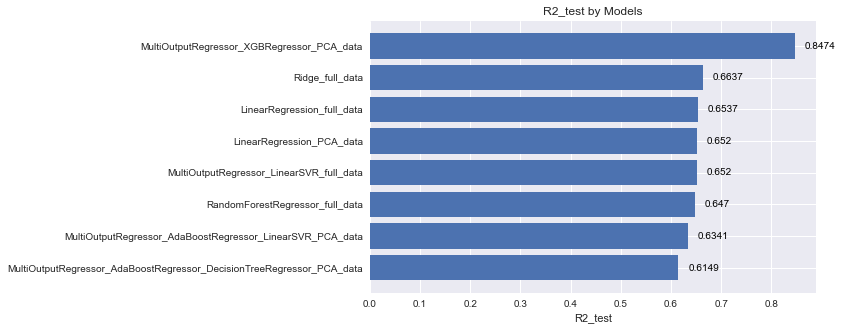

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
df = df_r2_diff.sort_values(by = ['r2_test'], ascending=True)
series = ax.barh( df['Model'], round(df['r2_test'], 4), left=0)
ax.set_xlabel('R2_test')
ax.set_title('R2_test by Models')
ax.bar_label(series, color='black', fontsize = 10, label_type='edge', padding=10)

plt.show()

По-долу са показани моделите, които дават статистически незначима разлика между коефициентите на определеност на тренировъчните и тестовите данни. Това са моделите, за които можем да твърдим, че с голяма вероятност __генерализарат__ добре. Т.е. че се справят еднакво добре с тренировъчните и тестовите данни.

A two sample z-test uses the following null and alternative hypotheses:<br>
- $H_0$: μ1 = μ2 (the two population means are equal)<br>
- $H_A$: μ1 ≠ μ2 (the two population means are not equal)<br>

In [38]:
df_r2_score = df_results[['Model', 'r2_train', 'r2_test', 'r2_diff, %', 'pval_ztest_r2','pval_ttest_r2']].sort_values(by = ['r2_test'], ascending=False)
df_r2_score[df_r2_score['pval_ztest_r2']>0.05]

,Model,r2_train,r2_test,"r2_diff, %",pval_ztest_r2,pval_ttest_r2
1,LinearRegression_PCA_data,0.651653,0.652037,-0.000384,0.551285,0.551851
3,MultiOutputRegressor_LinearSVR_full_data,0.651647,0.652036,-0.000388,0.557176,0.557732
6,MultiOutputRegressor_AdaBoostRegressor_LinearS...,0.634942,0.634084,0.000858,0.532036,0.532634


In [39]:
# средно за избраните
df_r2_score = df_r2_score[df_r2_score['pval_ztest_r2']>0.05]
df_r2_score['r2_test'].mean()

0.6460523591386441

MAE e средната стойност на абсолютните разлики между действителната и прогнозираната стойност. MAE е по-стабилна спрямо отклоненията в сравнение с MSE и е по-удобна метрика, ако данните са склонни към много отклонения.<br>
Сортираме по MAE за тестовия сет. 

In [40]:
df_mae_diff = df_results[['Model', 'mae_train', 'mae_test', 'mae_diff, %', 'pval_ztest_mae', 'pval_ttest_mae']].sort_values(by = ['mae_test'], ascending=True)


In [41]:
df_mae_diff.sort_values(by = ['mae_test'], ascending=True)

,Model,mae_train,mae_test,"mae_diff, %",pval_ztest_mae,pval_ttest_mae
7,MultiOutputRegressor_XGBRegressor_PCA_data,1067.397423,1332.452725,-265.055301,0.000000e+00,9.820662e-211
2,Ridge_full_data,1978.647057,1991.613015,-12.965959,1.831950e-03,2.057019e-03
0,LinearRegression_full_data,1969.697583,2019.765483,-50.067900,5.229046e-30,3.028144e-24
1,LinearRegression_PCA_data,2032.153384,2031.869390,0.283994,9.321200e-01,9.321916e-01
3,MultiOutputRegressor_LinearSVR_full_data,2032.219623,2031.918455,0.301168,9.280611e-01,9.281371e-01
4,RandomForestRegressor_full_data,1916.732286,2051.472176,-134.739889,1.472810e-228,6.608731e-89
6,MultiOutputRegressor_AdaBoostRegressor_LinearS...,2140.921013,2140.934120,-0.013107,9.983302e-01,9.983319e-01
5,MultiOutputRegressor_AdaBoostRegressor_Decisio...,2191.124899,2231.832014,-40.707115,4.983388e-36,5.265533e-28


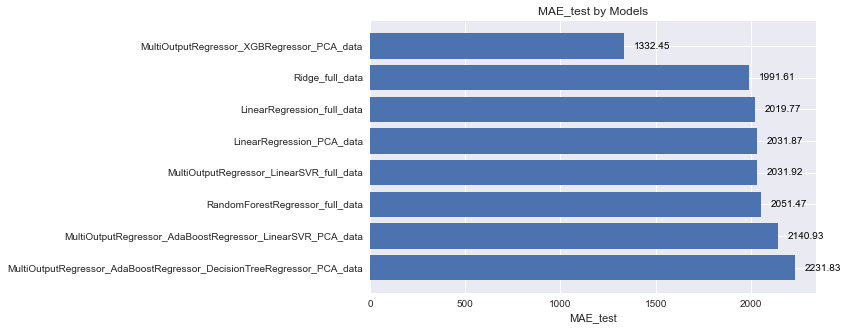

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))
df = df_mae_diff.sort_values(by = ['mae_test'], ascending=False)
series = ax.barh( df['Model'], round(df['mae_test'], 4), left=0)
ax.set_xlabel('MAE_test')
ax.set_title('MAE_test by Models')
ax.bar_label(series, color='black', fontsize = 10, label_type='edge', padding=10)

plt.show()

По-долу са показани моделите, които дават статистически незначима разлика между средната абсолютна грешка на тренировъчните и тестовите данни. Това са моделите, за които можем да твърдим, че с голяма вероятност __генерализарат__ добре. Т.е. че се справят еднакво добре с тренировъчните и тестовите данни. Отново тестваме горната хипотеза.

In [43]:
df_mae_score = df_results[['Model', 'mae_train', 'mae_test', 'mae_diff, %', 'pval_ztest_mae', 'pval_ttest_mae']].sort_values(by = ['mae_test'], ascending=True)
df_mae_score[df_mae_score['pval_ztest_mae']>0.05]

,Model,mae_train,mae_test,"mae_diff, %",pval_ztest_mae,pval_ttest_mae
1,LinearRegression_PCA_data,2032.153384,2031.869390,0.283994,0.932120,0.932192
3,MultiOutputRegressor_LinearSVR_full_data,2032.219623,2031.918455,0.301168,0.928061,0.928137
6,MultiOutputRegressor_AdaBoostRegressor_LinearS...,2140.921013,2140.934120,-0.013107,0.998330,0.998332


In [44]:
# средно за избраните
df_mae_score = df_mae_score[df_mae_score['pval_ztest_mae']>0.05]
df_mae_score['mae_test'].mean()

2068.2406548638537

In [45]:
df_results.to_csv(r'data/df_electricity_load_results.csv', index = False, header=True)

## <span style="color:midnightblue"> 6. CONSLUSIONS AND FURTHER RESEARCH<span>

В това проучване беше направено сравнение на ефективността на няколко алгоритми за машинно обучение за прогнозиране на генерацията на електроенергията с хоризонт 144 часа напред. Като цяло, средната оценка на по-стабилните модели не показа особено високи нива. Като се има предвид обаче, че искаме да прогнозираме цена, отдалечена на 6 дни напред във времето, това е в известна степен очакван резултат. Отделно, тук е мястото да се подчертае, че метеорологичните данни, с които разполагаме, касаят само 5 големи града на територията на Испания, което е доста ограничен ресурс. Не разполагаме с информация за модела, с който е направена съществуващата прогноза,  а и освен това тя касае друга задача (прогноза на средната генерирана мощност за ден напред), но предоставените тук модели са с по-слабо представяне.

По натък, за подобряване на прогнозата, може да се потърсят по-качествени метеорологични данни, както и за разработване на невронни мрежи.

Данните са интересни за изследване и на други проблеми в енергетиката, примерно като прогнозиране на аварии по мрежата. Или прогнозиране на общата генерация на електричество, както и генерацията по отделните видове източници. Тъй като данните съдържат информация и за генерирането на енергия от възобновяеми източници, която е много зависима от метеорологичните условия, би било интересно да се прогнозира количествено и този процес.


## <span style="color:midnightblue"> REFERENCES<span>

1. Scikit-learn open source machine learning library  https://scikit-learn.
2. Distributed (Deep) Machine Learning Community https://xgboost.readthedocs.io/en/stable/index.html
3. Kaggle https://www.kaggle.com/
4. Machine Learning Mastery https://machinelearningmastery.com
5. Saul Dobilas https://towardsdatascience.com/support-vector-regression-svr-one-of-the-most-flexible-yet-robust-prediction-algorithms-4d25fbdaca60